# INFO 3401 – Class 05: Reshaping and visualizing data

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

## Learning Objectives
This may review content you have learned in other classes, but we want to start with the same foundation since pandas is so fundamental to everything else we will do in this class!

* Understanding the benefits of tidy data
* Reshaping between long and tidy data
* Visualizing data using pandas and seaborn

## Load libraries

In [44]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sb

import re

# Pre-class lecture

In the pre-class lecture, we'll cover:

* What is tidy data? Long *vs*. wide data
* Reshaping data using `melt`, `stack`, `pivot`, and `crosstab`

## Tidy data: long *vs*. wide

Most of the data you are accustomed to using is likely "wide" data: rows for observations and columns for different variables. For example, you could imagine a table of data about U.S. state population growth where the rows are years, the columns are U.S. states, and the values are population. This would be considered "wide" data because there are more than 50 columns. 


| Year | Alabama | Alaska | ... | Wisconsin | Wyoming |
|------|:-------:|-------:|-----|-----------|---------|
| 1980 | 3893888 | 401851 |     | 4705767   | 469557  |
| 1990 | 4040587 | 550043 |     | 4891769   | 453588  |
| 2000 | 4447100 | 626932 |     | 5363675   | 493782  |
| 2010 | 4779736 | 910231 |     | 5686986   | 563626  |

"[Tidy data](https://vita.had.co.nz/papers/tidy-data.pdf)", in contrast, follows three rules:
1. Each variable forms a column
2. Each observation forms a row
3.  Each type of observational unit forms a table

A "tidy" representation of this state population table would look something like this. Filling in the gaps, this "tidied" data is obviously very "long".

| Year | State     | Population |
|------|-----------|------------|
| 1980 | Alabama   | 3893888    |
| 1980 | Alaska    | 401851     |
| ...  | ...       | ...        |
| 1980 | Wisconsin | 4705767    |
| 1980 | Wyoming   | 469557     |
| ...  | ...       | ...        |
| 2010 | Alabama   | 4779736    |
| 2010 | Alaska    | 910231     |
| ...  | ...       | ...        |
| 2010 | Wisconsin | 5686986    |
| 2010 | Wyoming   | 563626     |


As we discussed in the class slides, Hadley Wickham also calls these "messy data" because they have some common problems:
1. Column headers are values, not variable names
2. Multiple variables are stored in one column
3. Variables are stored in both rows and columns
4. Multiple types of observational units are stored in the same table
5. A single observational unit is stored in multiple tables

These critiques of common ways of storing and representing data are well-supported but that doesn't mean that tidy/long data is *always* better than messy/wide data. But it is really important that you're able to differentiate and convert between these two approaches to representing tabular data.

Let's load `cdc_weekly_deaths_cleaned.csv` and get a sense for how "messy" or "tidy" this data is.

In [2]:
cdc_df = pd.read_csv('cdc_weekly_deaths_cleaned.csv',encoding='utf8',parse_dates=['Ending Date'])
cdc_df.head()

,State,Year,Week,Ending Date,All Cause,Natural Cause,Septicemia,Malignant neoplasms,Diabetes mellitus,Alzheimer disease,Influenza and pneumonia,Chronic lower respiratory diseases,Other respiratory,Nephritis and nephrosis,Other,Diseases of heart,Cerebrovascular diseases,COVID-19 Multiple,COVID-19 Underlying
0,Alabama,2019,1,2019-01-05,1077.0,993.0,30.0,198.0,22.0,60.0,21.0,63.0,14.0,21.0,27.0,261.0,53.0,0.0,0.0
1,Alabama,2019,2,2019-01-12,1090.0,994.0,25.0,187.0,24.0,49.0,18.0,85.0,21.0,13.0,11.0,275.0,65.0,0.0,0.0
2,Alabama,2019,3,2019-01-19,1114.0,1042.0,22.0,238.0,18.0,48.0,31.0,80.0,30.0,25.0,15.0,283.0,53.0,0.0,0.0
3,Alabama,2019,4,2019-01-26,1063.0,994.0,21.0,165.0,22.0,50.0,22.0,113.0,14.0,25.0,23.0,279.0,56.0,0.0,0.0
4,Alabama,2019,5,2019-02-02,1095.0,1026.0,18.0,199.0,19.0,52.0,19.0,80.0,20.0,24.0,21.0,290.0,50.0,0.0,0.0


Using Wickham's messiness framework (the five common problems), what—if any—problems does our dataset have?

1. **Columns in headers are values, not variable names** 🡒 Maybe? You could make a case that disease names are values, not variables.
2. **Multiple variables are stored in one columns** 🡒 Maybe? Multiple [ICD codes](https://icd.codes/icd10cm/) are aggregated together for each column. But not fixable.
3. **Variables are stored in both rows and columns** 🡒 No. There are no variables in the rows, only values.
4. **Multiple types of data in the same table** 🡒 No. If there were state population data, this should be excluded.
5. **One types of data in multiple tables** 🡒 Maybe? It would be nice if there was data from before 2019 for more comparisons! ([there is](https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr) in Class 06)

To be clear, data being messy/wide or tidy/long is not binary: this CDC dataset is on the tidier/longer end of the spectrum. Messy/wide data is not necessarily "bad" and tidy/long data is not inherently "better." As we will see with the visualization tools during the in-class portion, there's many scenarios where we want our data to be wide for visualization purposes in one library (generally pandas) and other libraries expect the data to be tidy/long (generally seaborn).

## Reshaping data

### Pivoting data

We use pivots when data is long and we'd like it to be wide. We will use the [`pivot_table`](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) function to convert this long-ish data into a wide format. Confusingly, there is a `pivot` method and a `pivot_table` function and I would encourage you to use the latter since it include a powerful parameter called aggfunc that we'll discuss today briefly and in more depth on Friday.

![Pivoting data](https://pandas.pydata.org/docs/_images/reshaping_pivot.png)

In our CDC data example, perhaps we'd like to have a DataFrame with a single cause of death, the states as columns, and the weekly data as rows. We need to provide four parameters to the function:

* **data** 🡒 the original DataFrame
* **index** 🡒 which column in data to use as the index (rows) in the pivoted table
* **columns** 🡒 which column in data to use as the columns in the pivoted table
* **values** 🡒 which column in data to use as the values in the pivoted table

In [4]:
# Pivot, with parameters on new lines for clarity
cdc_covid_pivot_df = pd.pivot_table(data=cdc_df,
                                    index='Ending Date',
                                    columns='State',
                                    values='COVID-19 Multiple')

# Inspect
cdc_covid_pivot_df.tail(10)

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Ending Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-13,79.0,NaN,170.0,34.0,441.0,59.0,75.0,20.0,30.0,192.0,115.0,0.0,NaN,317.0,125.0,39.0,NaN,42.0,72.0,NaN,191.0,180.0,76.0,90.0,69.0,38.0,NaN,26.0,17.0,31.0,219.0,35.0,180.0,113.0,NaN,128.0,16.0,14.0,204.0,NaN,27.0,45.0,11.0,35.0,223.0,20.0,0.0,109.0,42.0,NaN,41.0,NaN
2020-06-20,88.0,0.0,203.0,45.0,451.0,38.0,38.0,NaN,28.0,217.0,93.0,0.0,0.0,262.0,110.0,32.0,19.0,25.0,84.0,NaN,134.0,131.0,56.0,67.0,71.0,42.0,NaN,22.0,20.0,13.0,160.0,24.0,126.0,100.0,NaN,105.0,18.0,12.0,182.0,NaN,33.0,57.0,12.0,59.0,296.0,14.0,NaN,86.0,31.0,NaN,37.0,NaN
2020-06-27,100.0,0.0,252.0,46.0,481.0,21.0,39.0,NaN,19.0,312.0,121.0,NaN,NaN,150.0,76.0,20.0,17.0,37.0,71.0,NaN,114.0,93.0,45.0,53.0,68.0,39.0,NaN,18.0,22.0,24.0,138.0,19.0,74.0,99.0,NaN,102.0,15.0,15.0,143.0,NaN,22.0,83.0,10.0,62.0,427.0,13.0,0.0,78.0,38.0,NaN,35.0,0.0
2020-07-04,117.0,NaN,365.0,39.0,613.0,23.0,22.0,NaN,16.0,440.0,142.0,NaN,NaN,140.0,61.0,20.0,12.0,35.0,85.0,NaN,91.0,67.0,40.0,44.0,90.0,38.0,NaN,12.0,43.0,14.0,99.0,25.0,61.0,94.0,NaN,97.0,20.0,20.0,134.0,NaN,17.0,127.0,NaN,71.0,776.0,21.0,0.0,55.0,43.0,NaN,23.0,NaN
2020-07-11,127.0,NaN,478.0,47.0,705.0,27.0,18.0,NaN,NaN,738.0,196.0,NaN,14.0,109.0,79.0,26.0,16.0,35.0,113.0,NaN,73.0,58.0,39.0,31.0,112.0,33.0,NaN,10.0,64.0,NaN,85.0,27.0,64.0,107.0,NaN,114.0,36.0,14.0,124.0,10.0,10.0,139.0,14.0,102.0,1192.0,33.0,NaN,64.0,54.0,NaN,19.0,NaN
2020-07-18,174.0,NaN,534.0,56.0,847.0,41.0,11.0,NaN,12.0,1091.0,256.0,NaN,26.0,87.0,61.0,40.0,24.0,34.0,144.0,NaN,60.0,35.0,33.0,37.0,123.0,45.0,NaN,NaN,84.0,NaN,59.0,28.0,58.0,113.0,NaN,107.0,46.0,27.0,106.0,11.0,NaN,220.0,NaN,108.0,1575.0,29.0,0.0,94.0,49.0,NaN,33.0,NaN
2020-07-25,233.0,NaN,454.0,69.0,948.0,32.0,NaN,NaN,NaN,1222.0,312.0,NaN,43.0,80.0,74.0,44.0,32.0,43.0,205.0,NaN,60.0,36.0,35.0,34.0,152.0,72.0,11.0,13.0,87.0,NaN,63.0,39.0,42.0,93.0,NaN,151.0,61.0,25.0,95.0,22.0,NaN,307.0,15.0,144.0,1609.0,44.0,0.0,86.0,71.0,NaN,52.0,NaN
2020-08-01,238.0,NaN,376.0,76.0,901.0,35.0,NaN,NaN,NaN,1160.0,296.0,NaN,47.0,81.0,69.0,48.0,34.0,43.0,181.0,NaN,76.0,29.0,48.0,32.0,197.0,61.0,15.0,13.0,94.0,NaN,58.0,34.0,38.0,11.0,NaN,116.0,62.0,27.0,98.0,30.0,NaN,263.0,NaN,148.0,1262.0,24.0,NaN,95.0,86.0,14.0,45.0,NaN
2020-08-08,210.0,NaN,266.0,76.0,798.0,37.0,0.0,NaN,NaN,913.0,295.0,NaN,38.0,91.0,61.0,52.0,28.0,30.0,164.0,NaN,61.0,27.0,33.0,41.0,165.0,79.0,12.0,16.0,101.0,NaN,35.0,18.0,30.0,NaN,NaN,68.0,53.0,21.0,128.0,36.0,NaN,216.0,NaN,135.0,726.0,28.0,0.0,77.0,57.0,13.0,56.0,NaN


As we'll get into more during class, pandas really likes to visualize wide data. Looking at all 50 states at once isn't that helpful, so let's compare four western states by passing their names as a list to the pivoted DataFrame and plotting the result.

Text(0, 0.5, 'Deaths')

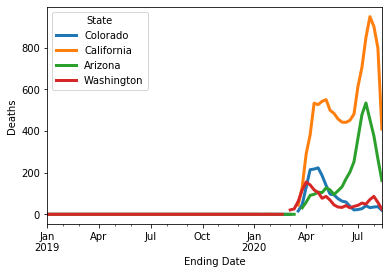

In [5]:
# Define four state names to focus on
four_states = ['Colorado','California','Arizona','Washington']

# Pass those names to the pivoted data frame to select only those columns
four_states_covid_pivot_df =  cdc_covid_pivot_df[four_states]

# Plot
ax = four_states_covid_pivot_df.plot(lw=3)

# Label your axes!
ax.set_ylabel('Deaths')

There's another really important parameter within `pivot_table` that will make more sense after class 06 but is worth starting to think about now: "aggfunc". 

Imagine we wanted the annual totals for each state for a given cause of death like heart disease ("Diseases of heart (I00-I09,I11,I13,I20-I51)"). Our index would be "MMWR Year", our columns would be states ("Jurisdiction of Occurrence"), and our values would be "Diseases of heart". But there are multiple occurrences of MMWR year for each state: what do we do with them all? The aggfunc parameter within `pivot_table` lets us specify what to do with repeated values. In our case, I'd like to add all repeated weekly values within a year together so I will use sum. We could just as easily use mean, first, and others.

In [6]:
# Pivot, with parameters on new lines for clarity
cdc_heart_pivot_df = pd.pivot_table(data = cdc_df,
                                    index = 'Year',
                                    columns = 'State',
                                    values = 'Diseases of heart',
                                    aggfunc = 'sum') # Get the totals for each state in a year

# Inspect
cdc_heart_pivot_df

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019,13275.0,810.0,12748.0,8527.0,62410.0,7915.0,7339.0,2011.0,1420.0,47946.0,19489.0,2567.0,3032.0,24931.0,14649.0,7444.0,5928.0,10679.0,11303.0,2924.0,11671.0,11860.0,25129.0,8321.0,7856.0,15344.0,2309.0,3553.0,7132.0,2695.0,18512.0,4138.0,25654.0,19653.0,1587.0,28911.0,10714.0,7067.0,32366.0,5365.0,2442.0,10419.0,1848.0,17510.0,46562.0,4025.0,1315.0,14908.0,11812.0,4952.0,12143.0,1017.0
2020,8681.0,496.0,8819.0,5126.0,40295.0,5016.0,3837.0,1349.0,904.0,31185.0,12328.0,1563.0,1928.0,16284.0,9307.0,4588.0,3689.0,6652.0,7335.0,1833.0,7694.0,7150.0,16402.0,5258.0,5317.0,9657.0,1434.0,2159.0,4528.0,1729.0,12563.0,2483.0,17005.0,10187.0,906.0,17824.0,6589.0,4408.0,19516.0,3018.0,1425.0,6759.0,1069.0,10996.0,30305.0,2630.0,911.0,9460.0,7383.0,2883.0,7582.0,641.0


Changing the aggfunc to other functions could also be relevant.

In [7]:
# Pivot, with parameters on new lines for clarity
cdc_heart_pivot_df = pd.pivot_table(data = cdc_df,
                                    index = 'Year',
                                    columns = 'State',
                                    values = 'Diseases of heart',
                                    aggfunc = 'first') # Get the totals for first week of each year

# Inspect
cdc_heart_pivot_df

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019,261.0,22.0,314.0,193.0,1425.0,190.0,161.0,37.0,35.0,979.0,437.0,53.0,63.0,524.0,305.0,157.0,147.0,211.0,240.0,59.0,255.0,243.0,500.0,170.0,169.0,286.0,52.0,75.0,171.0,62.0,378.0,97.0,574.0,391.0,29.0,608.0,220.0,149.0,648.0,113.0,49.0,201.0,34.0,358.0,984.0,80.0,19.0,272.0,248.0,94.0,256.0,26.0
2020,266.0,17.0,314.0,174.0,1391.0,177.0,158.0,50.0,33.0,1013.0,400.0,67.0,44.0,519.0,334.0,168.0,136.0,222.0,240.0,65.0,249.0,222.0,512.0,197.0,169.0,322.0,46.0,85.0,156.0,58.0,419.0,98.0,542.0,414.0,32.0,662.0,253.0,138.0,656.0,109.0,60.0,221.0,39.0,385.0,1000.0,76.0,25.0,297.0,246.0,101.0,270.0,30.0


In [8]:
# Pivot, with parameters on new lines for clarity
cdc_heart_pivot_df = pd.pivot_table(data = cdc_df,
                                    index = 'Year',
                                    columns = 'State',
                                    values = 'Diseases of heart',
                                    aggfunc = 'mean') # Get the averages for each year

# Inspect
cdc_heart_pivot_df

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019,255.288462,16.530612,245.153846,163.980769,1200.192308,152.211538,141.134615,38.673077,27.307692,922.038462,374.788462,49.365385,58.307692,479.442308,281.711538,143.153846,114.000000,205.365385,217.365385,56.230769,224.442308,228.076923,483.250000,160.019231,151.076923,295.076923,44.403846,68.326923,137.153846,51.826923,356.00000,79.576923,493.346154,377.942308,30.519231,555.980769,206.038462,135.903846,622.423077,103.173077,46.961538,200.365385,35.538462,336.730769,895.423077,77.403846,25.288462,286.692308,227.153846,95.230769,233.519231,19.557692
2020,263.060606,16.000000,267.242424,155.333333,1221.060606,152.000000,123.774194,40.878788,27.393939,945.000000,373.575758,47.363636,58.424242,493.454545,282.030303,139.030303,111.787879,201.575758,222.272727,55.545455,233.151515,216.666667,497.030303,159.333333,161.121212,292.636364,43.454545,65.424242,137.212121,52.393939,380.69697,75.242424,515.303030,339.566667,27.454545,540.121212,199.666667,133.575758,591.393939,94.312500,44.531250,204.818182,32.393939,333.212121,918.333333,79.696970,27.606061,286.666667,223.727273,90.093750,229.757576,20.031250


In [9]:
# Pivot, with parameters on new lines for clarity
cdc_heart_pivot_df = pd.pivot_table(data = cdc_df,
                                    index = 'Year',
                                    columns = 'State',
                                    values = 'Diseases of heart',
                                    aggfunc = 'count') # Get the number of observations

# Inspect
cdc_heart_pivot_df

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019,52,49,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52
2020,33,31,33,33,33,33,31,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,30,33,33,33,33,33,32,32,33,33,33,33,33,33,33,33,32,33,32


**Exercise**: Make a pivot table with "Week" as an index, "State" as a column, and "All Cause" as values. 

*Importantly*: does this need an aggfunc? Think about whether the combination of Week, State, and All Cause are unique or might have duplicate values across multiple years.

In [47]:
cdc_df.head()

,State,Year,Week,Ending Date,All Cause,Natural Cause,Septicemia,Malignant neoplasms,Diabetes mellitus,Alzheimer disease,Influenza and pneumonia,Chronic lower respiratory diseases,Other respiratory,Nephritis and nephrosis,Other,Diseases of heart,Cerebrovascular diseases,COVID-19 Multiple,COVID-19 Underlying
0,Alabama,2019,1,2019-01-05,1077.0,993.0,30.0,198.0,22.0,60.0,21.0,63.0,14.0,21.0,27.0,261.0,53.0,0.0,0.0
1,Alabama,2019,2,2019-01-12,1090.0,994.0,25.0,187.0,24.0,49.0,18.0,85.0,21.0,13.0,11.0,275.0,65.0,0.0,0.0
2,Alabama,2019,3,2019-01-19,1114.0,1042.0,22.0,238.0,18.0,48.0,31.0,80.0,30.0,25.0,15.0,283.0,53.0,0.0,0.0
3,Alabama,2019,4,2019-01-26,1063.0,994.0,21.0,165.0,22.0,50.0,22.0,113.0,14.0,25.0,23.0,279.0,56.0,0.0,0.0
4,Alabama,2019,5,2019-02-02,1095.0,1026.0,18.0,199.0,19.0,52.0,19.0,80.0,20.0,24.0,21.0,290.0,50.0,0.0,0.0


In [49]:
pd.pivot_table(data = cdc_df,
               index = 'Year',
               columns = 'State',
               values = 'All Cause',
               aggfunc='sum'
              )

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019,53055.0,4520.0,60951.0,32192.0,269955.0,39959.0,31815.0,9231.0,6022.0,209164.0,85945.0,11739.0,14302.0,105545.0,66243.0,30566.0,26663.0,48653.0,45983.0,14826.0,50320.0,59375.0,97469.0,45256.0,31949.0,64549.0,10404.0,17149.0,26356.0,12370.0,73994.0,18832.0,100194.0,96410.0,7373.0,123359.0,39610.0,37305.0,134823.0,29583.0,10561.0,49844.0,8374.0,75562.0,205837.0,19363.0,5653.0,69219.0,58027.0,22829.0,53851.0,4674.0
2020,36553.0,2719.0,47097.0,21499.0,188687.0,28446.0,21631.0,6627.0,4736.0,148995.0,58885.0,7417.0,9422.0,77630.0,45513.0,20080.0,17531.0,31104.0,33612.0,9583.0,36941.0,45513.0,69878.0,30444.0,23055.0,42129.0,6578.0,11091.0,18094.0,8387.0,64217.0,12708.0,77241.0,53362.0,4534.0,80693.0,25130.0,23762.0,91088.0,16878.0,7149.0,35562.0,5254.0,50615.0,144773.0,13090.0,3789.0,47667.0,38297.0,13601.0,35900.0,3106.0


### Melting data

If you felt that the names of the diseases are truly values rather than variables and shouldn't be in columns (Wickham's rule #1), we could make this data even tidier using [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.melt.html).

![Melting](https://pandas.pydata.org/docs/_images/reshaping_melt.png)

The first four columns (Jurisdiction, MMWR Year, MMWR Week, Week Ending Date) are all identifying variables and the remaining columns are all value variables. This DataFrame will get *really* long after this melting operation!

In [10]:
# Identifier variables
cdc_df.columns[:4]

Index(['State', 'Year', 'Week', 'Ending Date'], dtype='object')

In [11]:
# Value variables
cdc_df.columns[4:]

Index(['All Cause', 'Natural Cause', 'Septicemia', 'Malignant neoplasms',
       'Diabetes mellitus', 'Alzheimer disease', 'Influenza and pneumonia',
       'Chronic lower respiratory diseases', 'Other respiratory',
       'Nephritis and nephrosis', 'Other', 'Diseases of heart',
       'Cerebrovascular diseases', 'COVID-19 Multiple', 'COVID-19 Underlying'],
      dtype='object')

In [12]:
# Perform the melt! Function parameters on new lines for clarity
cdc_melted_df = pd.melt(cdc_df,
                        id_vars = cdc_df.columns[:4],
                        value_vars = cdc_df.columns[4:],
                        var_name = 'Disease', # Rename the variable column, comment out this line to see alternative
                        value_name = 'Count'  # Rename the value variable, comment out this line to see alternative
                       )

# Inspect
cdc_melted_df.head()

,State,Year,Week,Ending Date,Disease,Count
0,Alabama,2019,1,2019-01-05,All Cause,1077.0
1,Alabama,2019,2,2019-01-12,All Cause,1090.0
2,Alabama,2019,3,2019-01-19,All Cause,1114.0
3,Alabama,2019,4,2019-01-26,All Cause,1063.0
4,Alabama,2019,5,2019-02-02,All Cause,1095.0


In [13]:
cdc_melted_df.tail()

,State,Year,Week,Ending Date,Disease,Count
66265,Wyoming,2020,29,2020-07-18,COVID-19 Underlying,NaN
66266,Wyoming,2020,30,2020-07-25,COVID-19 Underlying,NaN
66267,Wyoming,2020,31,2020-08-01,COVID-19 Underlying,0.0
66268,Wyoming,2020,32,2020-08-08,COVID-19 Underlying,NaN
66269,Wyoming,2020,33,2020-08-15,COVID-19 Underlying,NaN


We will discuss visualizations in more detail during class, but seaborn can make some powerful plots with properly tidied data.

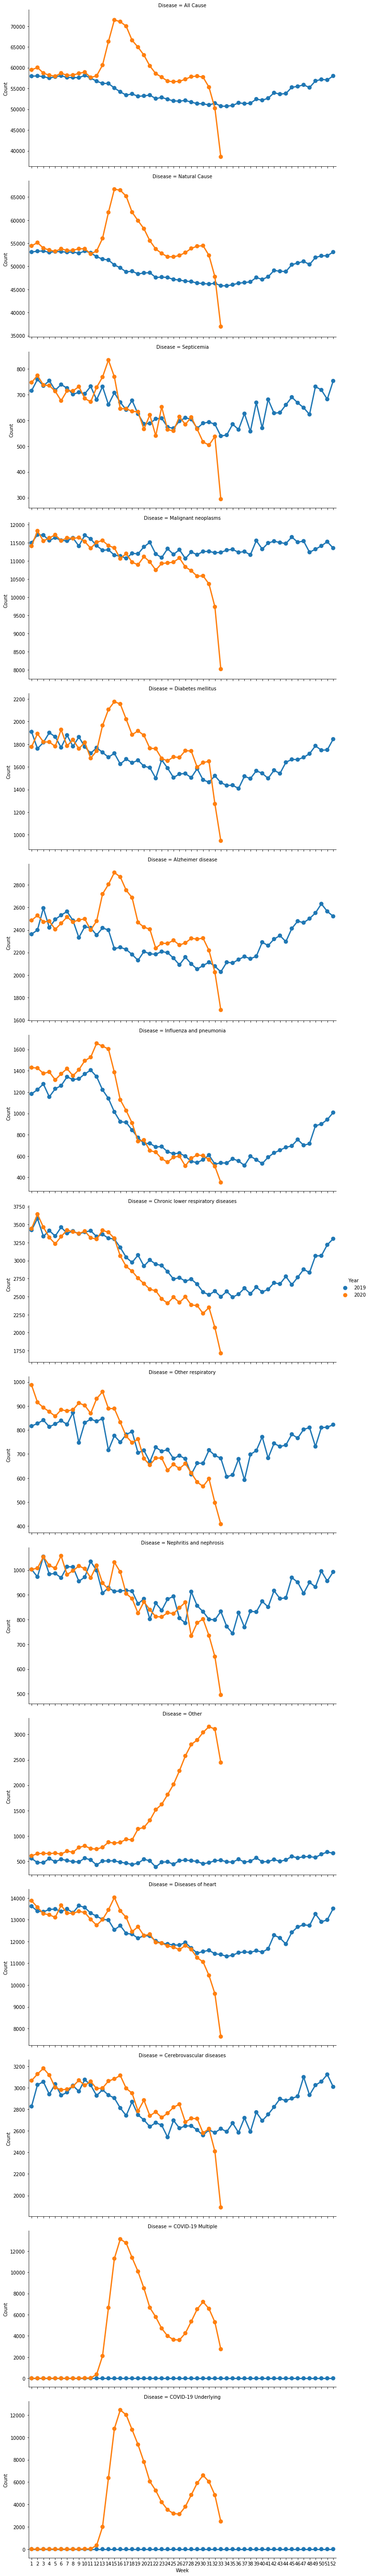

In [14]:
# There's a lot of data here and something like 14 charts to make, so this takes ~30 seconds
sb.catplot(data=cdc_melted_df,  # Specify data to use
           x='Week',            # x-axis
           y='Count',           # y-axis
           kind='point',        # point plots
           row='Disease',       # make a new plot for each kind of disease
           hue='Year',          # make two lines for each chart for year
           estimator=np.sum,    # "aggregate" points based on sum
           ci=0,                # remove distracting confidence intervals
           aspect=2,            # make the charts nice and wide
           sharey=False)        # let the charts have their own y-axes

### Stacking data

First, let's make the index do some work here by making the identifier variables a MultiIndex.

In [15]:
# Put the identifier variables into the index
cdc_indexed_df = cdc_df.set_index(cdc_df.columns[:4].tolist())
cdc_indexed_df.head(10)

All Cause  Natural Cause  Septicemia  \
State   Year Week Ending Date                                         
Alabama 2019 1    2019-01-05      1077.0          993.0        30.0   
             2    2019-01-12      1090.0          994.0        25.0   
             3    2019-01-19      1114.0         1042.0        22.0   
             4    2019-01-26      1063.0          994.0        21.0   
             5    2019-02-02      1095.0         1026.0        18.0   
             6    2019-02-09      1092.0         1005.0        18.0   
             7    2019-02-16      1103.0         1017.0        27.0   
             8    2019-02-23      1064.0          992.0        16.0   
             9    2019-03-02      1050.0          966.0        25.0   
             10   2019-03-09      1062.0          964.0        18.0   

                               Malignant neoplasms  Diabetes mellitus  \
State   Year Week Ending Date                                           
Alabama 2019 1    2019-01-05                 198.0               22.0   
             2    2019-01-12                 187.0               24.0   
             3    2019-01-19                 238.0               18.0   
             4    2019-01-26                 165.0               22.0   
             5    2019-02-02                 199.0               19.0   
             6    2019-02-09                 182.0               25.0   
             7    2019-02-16                 214.0               25.0   
             8    2019-02-23                 183.0               22.0   
             9    2019-03-02                 164.0               30.0   
             10   2019-03-09                 189.0               27.0   

                               Alzheimer disease  Influenza and pneumonia  \
State   Year Week Ending Date                                               
Alabama 2019 1    2019-01-05                60.0                     21.0   
             2    2019-01-12                49.0                     18.0   
             3    2019-01-19                48.0                     31.0   
             4    2019-01-26                50.0                     22.0   
             5    2019-02-02                52.0                     19.0   
             6    2019-02-09                56.0                     28.0   
             7    2019-02-16                51.0                     27.0   
             8    2019-02-23                52.0                     17.0   
             9    2019-03-02                52.0                     28.0   
             10   2019-03-09                50.0                     19.0   

                               Chronic lower respiratory diseases  \
State   Year Week Ending Date                                       
Alabama 2019 1    2019-01-05                                 63.0   
             2    2019-01-12                                 85.0   
             3    2019-01-19                                 80.0   
             4    2019-01-26                                113.0   
             5    2019-02-02                                 80.0   
             6    2019-02-09                                 76.0   
             7    2019-02-16                                 78.0   
             8    2019-02-23                                 70.0   
             9    2019-03-02                                 65.0   
             10   2019-03-09                                 81.0   

                               Other respiratory  Nephritis and nephrosis  \
State   Year Week Ending Date                                               
Alabama 2019 1    2019-01-05                14.0                     21.0   
             2    2019-01-12                21.0                     13.0   
             3    2019-01-19                30.0                     25.0   
             4    2019-01-26                14.0                     25.0   
             5    2019-02-02                20.0                     24.0   
        

We can then call the [`.stack`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.stack.html) method to convert the columns into index as well, basically melting what had been a wide DataFrame into a very long Series!

![Stack](https://pandas.pydata.org/pandas-docs/stable/_images/reshaping_stack.png)

In [16]:
cdc_indexed_df.stack()

State    Year  Week  Ending Date                         
Alabama  2019  1     2019-01-05   All Cause                  1077.0
                                  Natural Cause               993.0
                                  Septicemia                   30.0
                                  Malignant neoplasms         198.0
                                  Diabetes mellitus            22.0
                                                              ...  
Wyoming  2020  33    2020-08-15   Septicemia                    0.0
                                  Malignant neoplasms          18.0
                                  Alzheimer disease             0.0
                                  Other respiratory             0.0
                                  Nephritis and nephrosis       0.0
Length: 53498, dtype: float64

### Unstacking data

Some of the identifier variables are redundant, so let's reduce it to the two key columns. Furthermore, let's make use of the powerful indexing capabilities of pandas to show how to stack data.

First, imagine we were given a MultiIndexed Series `cdc_s` of data resembling the melted data from the previous section. Don't worry about how we made it right now, just focus on the output `cdc_s`. It contains an index with three different levels: "State", "Ending Date", and "Disease" and the Series values are the counts of disease on that day.

In [17]:
cdc_s = cdc_melted_df[['State','Ending Date','Disease','Count']].set_index(['State','Ending Date','Disease'])['Count']

cdc_s.head(20)

State    Ending Date  Disease  
Alabama  2019-01-05   All Cause    1077.0
         2019-01-12   All Cause    1090.0
         2019-01-19   All Cause    1114.0
         2019-01-26   All Cause    1063.0
         2019-02-02   All Cause    1095.0
         2019-02-09   All Cause    1092.0
         2019-02-16   All Cause    1103.0
         2019-02-23   All Cause    1064.0
         2019-03-02   All Cause    1050.0
         2019-03-09   All Cause    1062.0
         2019-03-16   All Cause    1090.0
         2019-03-23   All Cause    1012.0
         2019-03-30   All Cause    1079.0
         2019-04-06   All Cause    1044.0
         2019-04-13   All Cause    1031.0
         2019-04-20   All Cause     954.0
         2019-04-27   All Cause    1042.0
         2019-05-04   All Cause    1031.0
         2019-05-11   All Cause    1009.0
         2019-05-18   All Cause     996.0
Name: Count, dtype: float64

We can conver this really long (but tidy!) data back into a more human-interpretable format by using the [`.unstack()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html) method. This basically takes some level(s) of a MultiIndex and turns them into columns!

![Unstack](https://pandas.pydata.org/pandas-docs/stable/_images/reshaping_unstack.png)

We can unstack the State part of the index and move it to the columns

In [18]:
cdc_s.unstack('State')

State                                 Alabama  Alaska  Arizona  Arkansas  \
Ending Date Disease                                                        
2019-01-05  All Cause                  1077.0    93.0   1351.0     692.0   
            Alzheimer disease            60.0     NaN     61.0      29.0   
            COVID-19 Multiple             0.0     0.0      0.0       0.0   
            COVID-19 Underlying           0.0     0.0      0.0       0.0   
            Cerebrovascular diseases     53.0     NaN     59.0      27.0   
...                                       ...     ...      ...       ...   
2020-08-15  Natural Cause               726.0    27.0   1133.0     539.0   
            Nephritis and nephrosis       NaN     NaN     11.0       NaN   
            Other                        13.0     NaN    104.0      15.0   
            Other respiratory            18.0     0.0     15.0       NaN   
            Septicemia                    NaN     0.0      NaN       NaN   

State                                 California  Colorado  Connecticut  \
Ending Date Disease                                                       
2019-01-05  All Cause                     5692.0     836.0        631.0   
            Alzheimer disease              316.0      40.0         15.0   
            COVID-19 Multiple                0.0       0.0          0.0   
            COVID-19 Underlying              0.0       0.0          0.0   
            Cerebrovascular diseases       339.0      50.0         31.0   
...                                          ...       ...          ...   
2020-08-15  Natural Cause                 4096.0     629.0          NaN   
            Nephritis and nephrosis         67.0       NaN          0.0   
            Other                          263.0      81.0          NaN   
            Other respiratory               36.0       NaN          0.0   
            Septicemia                      24.0       NaN          0.0   

State                                 Delaware  District of Columbia  Florida  \
Ending Date Disease                                                             
2019-01-05  All Cause                    185.0                 130.0   4220.0   
            Alzheimer disease              NaN                   NaN    134.0   
            COVID-19 Multiple              0.0                   0.0      0.0   
            COVID-19 Underlying            0.0                   0.0      0.0   
            Cerebrovascular diseases      13.0                   NaN    252.0   
...                                        ...                   ...      ...   
2020-08-15  Natural Cause                111.0                  71.0   3621.0   
            Nephritis and nephrosis        NaN                   0.0     61.0   
            Other                          NaN                   NaN    304.0   
            Other respiratory              NaN                   NaN     30.0   
            Septicemia                     0.0                   NaN     35.0   

State                                 Georgia  Hawaii  Idaho  Illinois  \
Ending Date Disease                                                      
2019-01-05  All Cause                  1803.0   246.0  271.0    2176.0   
            Alzheimer disease            75.0    10.0    NaN      80.0   
            COVID-19 Multiple             0.0     0.0    0.0       0.0   
            COVID-19 Underlying           0.0     0.0    0.0       0.0   
            Cerebrovascular diseases     83.0    17.0   11.0      96.0   
...                                       ...     ...    ...       ...   
2020-08-15  Natural Cause               905.0   185.0  184.0    1749.0   
            Nephritis and nephrosis      18.0     NaN    NaN      32.0   
            Other                        18.0    43.0    NaN     188.0   
            Other respiratory            20.0     NaN    NaN      13.0   
            Septicemia                   18.0     NaN    0.0      26.0   

State             

We can unstack the "Ending Date":

In [19]:
cdc_s.unstack('Ending Date')

Ending Date                       2019-01-05  2019-01-12  2019-01-19  \
State   Disease                                                        
Alabama All Cause                     1077.0      1090.0      1114.0   
        Alzheimer disease               60.0        49.0        48.0   
        COVID-19 Multiple                0.0         0.0         0.0   
        COVID-19 Underlying              0.0         0.0         0.0   
        Cerebrovascular diseases        53.0        65.0        53.0   
...                                      ...         ...         ...   
Wyoming Natural Cause                   84.0        86.0        75.0   
        Nephritis and nephrosis          NaN         0.0         NaN   
        Other                            0.0         NaN         0.0   
        Other respiratory                NaN         NaN         NaN   
        Septicemia                       NaN         NaN         NaN   

Ending Date                       2019-01-26  2019-02-02  2019-02-09  \
State   Disease                                                        
Alabama All Cause                     1063.0      1095.0      1092.0   
        Alzheimer disease               50.0        52.0        56.0   
        COVID-19 Multiple                0.0         0.0         0.0   
        COVID-19 Underlying              0.0         0.0         0.0   
        Cerebrovascular diseases        56.0        50.0        59.0   
...                                      ...         ...         ...   
Wyoming Natural Cause                   82.0        66.0        92.0   
        Nephritis and nephrosis          NaN         NaN         0.0   
        Other                            NaN         NaN         NaN   
        Other respiratory                0.0         NaN         NaN   
        Septicemia                       0.0         0.0         0.0   

Ending Date                       2019-02-16  2019-02-23  2019-03-02  \
State   Disease                                                        
Alabama All Cause                     1103.0      1064.0      1050.0   
        Alzheimer disease               51.0        52.0        52.0   
        COVID-19 Multiple                0.0         0.0         0.0   
        COVID-19 Underlying              0.0         0.0         0.0   
        Cerebrovascular diseases        56.0        52.0        56.0   
...                                      ...         ...         ...   
Wyoming Natural Cause                   87.0        82.0        71.0   
        Nephritis and nephrosis          0.0         NaN         NaN   
        Other                            NaN         NaN         0.0   
        Other respiratory                NaN         0.0         0.0   
        Septicemia                       NaN         0.0         0.0   

Ending Date                       2019-03-09  2019-03-16  2019-03-23  \
State   Disease                                                        
Alabama All Cause                     1062.0      1090.0      1012.0   
        Alzheimer disease               50.0        60.0        48.0   
        COVID-19 Multiple                0.0         0.0         0.0   
        COVID-19 Underlying              0.0         0.0         0.0   
        Cerebrovascular diseases        63.0        57.0        62.0   
...                                      ...         ...         ...   
Wyoming Natural Cause                   82.0        97.0        77.0   
        Nephritis and nephrosis          NaN         NaN         NaN   
        Other                            NaN         0.0         0.0   
        Other respiratory                NaN         0.0         0.0   
        Septicemia                       0.0         0.0         NaN   

Ending Date                       2019-03-30  2019-04-06  2019-04-13  \
State   Disease                                                        
Alabama All Cause                     1079.0      1044.0      1031.0   
        Alzheimer disease           

Or the "Disease":

In [20]:
cdc_s.unstack('Disease')

Disease              All Cause  Alzheimer disease  COVID-19 Multiple  \
State   Ending Date                                                    
Alabama 2019-01-05      1077.0               60.0                0.0   
        2019-01-12      1090.0               49.0                0.0   
        2019-01-19      1114.0               48.0                0.0   
        2019-01-26      1063.0               50.0                0.0   
        2019-02-02      1095.0               52.0                0.0   
...                        ...                ...                ...   
Wyoming 2020-07-18        98.0                NaN                NaN   
        2020-07-25        93.0                NaN                NaN   
        2020-08-01        80.0                NaN                NaN   
        2020-08-08        89.0                NaN                NaN   
        2020-08-15        60.0                0.0                NaN   

Disease              COVID-19 Underlying  Cerebrovascular diseases  \
State   Ending Date                                                  
Alabama 2019-01-05                   0.0                      53.0   
        2019-01-12                   0.0                      65.0   
        2019-01-19                   0.0                      53.0   
        2019-01-26                   0.0                      56.0   
        2019-02-02                   0.0                      50.0   
...                                  ...                       ...   
Wyoming 2020-07-18                   NaN                       NaN   
        2020-07-25                   NaN                       NaN   
        2020-08-01                   0.0                       NaN   
        2020-08-08                   NaN                       NaN   
        2020-08-15                   NaN                       NaN   

Disease              Chronic lower respiratory diseases  Diabetes mellitus  \
State   Ending Date                                                          
Alabama 2019-01-05                                 63.0               22.0   
        2019-01-12                                 85.0               24.0   
        2019-01-19                                 80.0               18.0   
        2019-01-26                                113.0               22.0   
        2019-02-02                                 80.0               19.0   
...                                                 ...                ...   
Wyoming 2020-07-18                                  NaN                NaN   
        2020-07-25                                  NaN                NaN   
        2020-08-01                                  NaN                NaN   
        2020-08-08                                  NaN                NaN   
        2020-08-15                                  NaN                NaN   

Disease              Diseases of heart  Influenza and pneumonia  \
State   Ending Date                                               
Alabama 2019-01-05               261.0                     21.0   
        2019-01-12               275.0                     18.0   
        2019-01-19               283.0                     31.0   
        2019-01-26               279.0                     22.0   
        2019-02-02               290.0                     19.0   
...                                ...                      ...   
Wyoming 2020-07-18                20.0                      NaN   
        2020-07-25                16.0                      NaN   
        2020-08-01                16.0                      NaN   
        2020-08-08                17.0                      NaN   
        2020-08-15                 NaN                      NaN   

Disease              Malignant neoplasms  Natural Cause  \
State   Ending Date                                       
Alabama 2019-01-05                 198.0          993.0   
        2019-01-12                 187.0          994.0   
        2019-01-19           

### Crosstab-ing data

[`crosstab`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) is similar in many ways to `pivot_table` in that counts the values in a larger DataFrame as a simpler DataFrame. I prefer `pivot_table` to `crosstab` because pivot_table can do more (like create multi-indexed columns and indices), but it's common to hear analysts, pundits, *etc*. say things like "show me the cross-tabs" which generally means show me aggregated numbers (financials, polls, *etc*.) broken down by differen sub-categories.

We can mas a crosstab of our CDC data using the "State" as an index, "Year" as columns, the number of "Influenza and pneumonia" deaths as values, and "sum" as our aggfunc.

In [21]:
pd.crosstab(index=cdc_df['State'],
            columns=cdc_df['Year'],
            values=cdc_df['Influenza and pneumonia'],
            aggfunc='sum').head(10) # I added a .head() to inspect

Year,2019,2020
State,,
Alabama,962.0,719.0
Alaska,0.0,0.0
Arizona,952.0,822.0
Arkansas,447.0,402.0
California,5627.0,4315.0
Colorado,282.0,254.0
Connecticut,431.0,273.0
Delaware,0.0,10.0
District of Columbia,0.0,0.0


You can do exactly the same thing with `pivot_table` and doesn't it just *feel* better?

In [22]:
pd.pivot_table(cdc_df,
               index='State',
               columns='Year',
               values='Influenza and pneumonia',
               aggfunc='sum').head(10) # I added a .head() to inspect

Year,2019,2020
State,,
Alabama,962.0,719.0
Alaska,0.0,0.0
Arizona,952.0,822.0
Arkansas,447.0,402.0
California,5627.0,4315.0
Colorado,282.0,254.0
Connecticut,431.0,273.0
Delaware,0.0,10.0
District of Columbia,0.0,0.0


**Exercise**: Make a crosstab (or pivot table) of weekly heart disease deaths by year. Use "week" as an index, "year" as columns, "Diseases of heart" as values, and "sum" as an aggfunc. Sort on the 2019 column and make a hypothesis for why that week was particularly bad.

In [56]:
cdc_df.head()

,State,Year,Week,Ending Date,All Cause,Natural Cause,Septicemia,Malignant neoplasms,Diabetes mellitus,Alzheimer disease,Influenza and pneumonia,Chronic lower respiratory diseases,Other respiratory,Nephritis and nephrosis,Other,Diseases of heart,Cerebrovascular diseases,COVID-19 Multiple,COVID-19 Underlying
0,Alabama,2019,1,2019-01-05,1077.0,993.0,30.0,198.0,22.0,60.0,21.0,63.0,14.0,21.0,27.0,261.0,53.0,0.0,0.0
1,Alabama,2019,2,2019-01-12,1090.0,994.0,25.0,187.0,24.0,49.0,18.0,85.0,21.0,13.0,11.0,275.0,65.0,0.0,0.0
2,Alabama,2019,3,2019-01-19,1114.0,1042.0,22.0,238.0,18.0,48.0,31.0,80.0,30.0,25.0,15.0,283.0,53.0,0.0,0.0
3,Alabama,2019,4,2019-01-26,1063.0,994.0,21.0,165.0,22.0,50.0,22.0,113.0,14.0,25.0,23.0,279.0,56.0,0.0,0.0
4,Alabama,2019,5,2019-02-02,1095.0,1026.0,18.0,199.0,19.0,52.0,19.0,80.0,20.0,24.0,21.0,290.0,50.0,0.0,0.0


In [57]:
cdc_week_year_heart = pd.pivot_table(cdc_df,
               index='Ending Date',
               columns='Year',
               values='Diseases of heart',
               aggfunc='sum')

cdc_week_year_heart.sort_values(2019,ascending=False)

Year,2019,2020
Ending Date,,
2019-03-02,13653.0,NaN
2019-01-05,13624.0,NaN
2019-03-09,13565.0,NaN
2019-12-28,13517.0,NaN
2019-02-16,13500.0,NaN
...,...,...
2020-07-18,NaN,11258.0
2020-07-25,NaN,11064.0
2020-08-01,NaN,10441.0


# In-class

In class lecture, we'll cover:

* Fundamentals of plotting with pyplot
* Visualizing wide data using pandas
* Visualizing tidy data using seaborn

## Fundamentals of matplotlib

[matplotlib](https://matplotlib.org/) is the basic library in [Python scientific computing ecosystem](https://www.scipy.org/) for visualizing data. Everyone from the teams of hundreds of physicists researching [colliding black holes](https://www.gw-openscience.org/tutorials/) and [particle accelerators](https://swan.web.cern.ch/swan/content/basic-examples.html) down to undergraduates like yourselves use matplotlib for visualizing their data within Python. matplotlib is designed to play with numpy and both of them predate pandas by approximately a decade. This means all of the examples you see in the matplotlib documentation start with numpy rather than pandas. But when we use pandas or seaborn to visualize data, at the end of the day they are generating matplotlib `Figures` and `Axes`.

matplotlib is both very powerful and very frustrating. Abe and I do not have all the answers and it's unlikely there's anyone in the world who knows how to do everything with it since it can do *so* much. This is not meant to scare you, it's just so that you calibrate your expectations and realize that *every data scientist using Python **also** gets frustrated with matplotlib*. You *will* need to use resources like their user guides, documentation, and community Q&A resources like StackOverflow: just make sure to cite them when you use them!

I always find matplotlib's [tutorials](https://matplotlib.org/tutorials/index.html) and [gallery of examples](https://matplotlib.org/gallery/index.html) super-helpful, especially this image showing all the different parts of a matplotlib figure that can be customized in different ways. The [Lifecycle of a Plot](https://matplotlib.org/tutorials/introductory/lifecycle.html) is also a nice resource for beginners that we will emulate below. Finally, any data scientist who visualizes data has Googled or bookmarked the matplotlib [colormaps](https://matplotlib.org/tutorials/colors/colormaps.html) documentation, so you should too!

![Anatomy of a matplotlib figure](https://matplotlib.org/_images/anatomy.png)

Again, keep in mind that a lot of the examples you see in the matplotlib gallery can often be done in pandas with much less code (pandas takes care of a lot for you under the hood!). Which is why you should also check out the pandas [Visualization](https://pandas.pydata.org/docs/user_guide/visualization.html) user guide.

Let's start by making some data we can use as an example.

In [ ]:
# Boolean index to only 2020 data
cdc_2020_df = cdc_df[cdc_df['Year'] == 2020]

# Pivot data to get total deaths in 2020 from all and natural causes by week
weekly_all_natural_cause = pd.pivot_table(cdc_2020_df,index='Week',values=['All Cause','Natural Cause'],aggfunc='sum')

# Inspect
weekly_all_natural_cause.tail()

Now this is a pandas DataFrame with a single Series. We could—and should—use all the powerful visualization functionality that pandas includes to visualize it. We will in the next section. 

But I'm going to take an unnecessary and extra step to turn this data into a numpy array so that it looks like the data you find in the matplotlib tutorials so that we can cover some important basics.

In [ ]:
# Turn the pandas Series into a numpy arrays
weekly_all_cause_array = weekly_all_natural_cause['All Cause'].values
weekly_natural_cause_array = weekly_all_natural_cause['Natural Cause'].values
weekly_index_array = weekly_all_natural_cause.index.values

# Inspect one
weekly_all_cause_array

There are [two philosophies](https://matplotlib.org/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface) for generating plots within matplotlib: the **object-oriented style** and the **pyplot interface**. We are going to use the object-oriented style throughout this class since the pyplot interface style can be brittle in many scenarios we care about when using pandas, seaborn,  and other libraries later in class. At the core of the object-oreinted style is creating the figures and axes explicitly and calling methods and attributes on them to customize them.

What does that mean? It means you need to start with an empty figure and put stuff in it. A matplotlib visualization consists of a `Figure` which contains at least one `Axes` where the data goes. A `Figure` could have multiple axes (more on that in a second!) where we put visualizations side-by-side. We use pyplot's [`subplots`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html) function to create an empty figure and axes and assign them variables.

In [ ]:
# Create an empty figure and axes
f,ax = plt.subplots()

Let's put the CDC data we made above (`weekly_all_cause_array`,`weekly_natural_cause_array`) in it.

In [ ]:
# Create an empty figure and axes
f,ax = plt.subplots()

# Change the empty axis object to include a line plot of the weekly_all_cause_array data
ax.plot(weekly_index_array,      # x-axis data
        weekly_all_cause_array,  # y-axis data
        label='All Cause')

# Label your plot!
ax.set_title('2020 U.S. Deaths')
ax.set_xlabel('Week')
ax.set_ylabel('Count')

# Add a legend
ax.legend()

Contrast this with a scatter plot.

In [ ]:
# Create an empty figure and axes
f,ax = plt.subplots()

# Change the empty axis object to include a scatter plot of the weekly_all_cause_array data
ax.scatter(weekly_index_array,   # x-axis data
        weekly_all_cause_array,  # y-axis data
        label='All Cause')

# Label your plot!
ax.set_title('2020 U.S. Deaths')
ax.set_xlabel('Week')
ax.set_ylabel('Count')

# Add a legend
ax.legend()

Or a bar plot.

In [ ]:
# Create an empty figure and axes
f,ax = plt.subplots()

# Change the empty axis object to include a bar plot of the weekly_all_cause_array data
ax.bar(weekly_index_array,   # x-axis data
        weekly_all_cause_array,  # y-axis data
        label='All Cause')

# Label your plot!
ax.set_title('2020 U.S. Deaths')
ax.set_xlabel('Week')
ax.set_ylabel('Count')

# Add a legend
ax.legend()

There are endless ways you could continue to customize this chart to make it look better: thicker line, different color, different ticks, adding or removing spines and grids (look back up at the "Anatomy of a figure" above) and the [Lifecycle of a Plot](https://matplotlib.org/tutorials/introductory/lifecycle.html) guide.

You may want to put two kinds of data on the same chart. Call `.plot` on the `ax` object a second time. If you had more than two lines of data to include, you could write a loop. But pandas will take care of all this for you when we get there.

In [ ]:
# Create an empty figure and axes objects
f,ax = plt.subplots()

# Change the empty axes object to include a line plot of the weekly_all_cause_array data
ax.plot(weekly_index_array,      # x-axis data
        weekly_all_cause_array,  # y-axis data
        label='All Cause',
        c='k',                   # make the line color black
        lw=5,                    # make the line thicker
       )

# Add another plot to the axes object
ax.plot(weekly_index_array,      # x-axis data
        weekly_natural_cause_array,  # y-axis data
        label='Natural Cause',
        c='b'                    # make the line color blue
       )

# Label your plot!
ax.set_title('2020 U.S. Deaths')
ax.set_xlabel('Week')
ax.set_ylabel('Count')

# Add a red dashed line to mark a significant date
ax.axvline(x=15,c='r',ls='--')

# Add an annotation: https://matplotlib.org/3.2.2/tutorials/text/annotations.html
ax.annotate(s='Week ending April 11',
            xytext=(0,45000),
            c='r',
            arrowprops={'arrowstyle':'->','lw':2,'color':'r'},
            xy=(15,50000)
           )

ax.annotate(s='Missing data starts',
            xytext=(16,40000),
            c='r',
            arrowprops={'arrowstyle':'->','lw':2,'color':'r'},
            xy=(30,52500)
           )

# Add a legend
ax.legend()

Let's finish with a common task of putting two visualizations side-by-side. Again, track down that [documentation for multiple subplots](https://matplotlib.org/gallery/subplots_axes_and_figures/subplot.html) and use the computational thinking tools from your data science mindset around experimenting, iterating, debugging, and modularizing.

In [ ]:
f,axs = plt.subplots(ncols=2,figsize=(12,4))

In [ ]:
# Create an empty figure with two axes objects and define a different figure size
# axs is a list containing the axes to which you can add plots, titles, etc.
f,axs = plt.subplots(ncols=2,figsize=(12,4))

# Select the first axes object in the axs list and add a plot
axs[0].plot(weekly_index_array,weekly_all_cause_array,c='k',lw=5)

# Select the other axes object in the axs list and add a plot
axs[1].plot(weekly_index_array,weekly_natural_cause_array,c='b',lw=5)

# Label each plot
axs[0].set_title('2020 U.S. Deaths, All Causes')
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Count')

axs[1].set_title('2020 U.S. Deaths, Natural Causes')
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Count')

# This time loop through the list of axes instead of writing all this code multiple times
for _ax in axs:
    
    # Add a red dashed line to mark a significant date
    _ax.axvline(x=15,c='r',ls='--')

    # Add an annotation: https://matplotlib.org/3.2.2/tutorials/text/annotations.html
    _ax.annotate(text='Week ending April 11',
            xytext=(0,45000),
            c='r',
            arrowprops={'arrowstyle':'->','lw':2,'color':'r'},
            xy=(15,50000)
           )

    _ax.annotate(text='Missing data starts',
            xytext=(16,40000),
            c='r',
            arrowprops={'arrowstyle':'->','lw':2,'color':'r'},
            xy=(30,52500)
           )

**Exercise**: Experiment, break, and fix different parts of any of the code above! New colors, different line widths and styles, try to stack the charts across multiple columns, add other annotations, see what the sharey parameter does in `subplots`! Do *anything* to make it your own!

## Visualizing wide data using pandas

So now you have some idea that matplotlib is the core of all visualization in Python, plots are made of a `Figure` and 1 or more `Axes` objects, and we use the object-oriented style to customize these objects with plots, labels, and annotations. But making a single plot took a few lines of code to pull off.

Let's return back to our `weekly_all_natural_cause` DataFrame we made above.

In [ ]:
weekly_all_natural_cause.head()

pandas also has a `.plot` method that we can call on `Series` and `DataFrame` objects. What does it do?

In [ ]:
weekly_all_natural_cause.plot()

Well that was easy! Thanks pandas!

If we wanted to customize it like we had in the previous charts, we can employ our object-oriented style. The pandas `.plot` method returns an `Axes` object that we can assign and manipulate.

In [ ]:
ax = weekly_all_natural_cause.plot()

# Label your plot!
ax.set_title('2020 U.S. Deaths')
ax.set_xlabel('Week')
ax.set_ylabel('Count')

# Add a red dashed line to mark a significant date
ax.axvline(x=15,c='r',ls='--')

# Add an annotation: https://matplotlib.org/3.2.2/tutorials/text/annotations.html
ax.annotate(text='Week ending April 11',
            xytext=(0,45000),
            c='r',
            arrowprops={'arrowstyle':'->','lw':2,'color':'r'},
            xy=(15,50000)
           )

ax.annotate(text='Missing data starts',
            xytext=(16,40000),
            c='r',
            arrowprops={'arrowstyle':'->','lw':2,'color':'r'},
            xy=(30,52500)
           )

Customize the properties of the lines inside the `.plot` method.

In [ ]:
ax = weekly_all_natural_cause.plot(lw=3,color=['grey','green'])

# Label your plot!
ax.set_title('2020 U.S. Deaths')
ax.set_xlabel('Week')
ax.set_ylabel('Count')

# Add a red dashed line to mark a significant date
ax.axvline(x=15,c='r',ls='--')

# Add an annotation: https://matplotlib.org/3.2.2/tutorials/text/annotations.html
ax.annotate(text='Week ending April 11',
            xytext=(0,45000),
            c='r',
            arrowprops={'arrowstyle':'->','lw':2,'color':'r'},
            xy=(15,50000)
           )

ax.annotate(text='Missing data starts',
            xytext=(16,40000),
            c='r',
            arrowprops={'arrowstyle':'->','lw':2,'color':'r'},
            xy=(30,52500)
           )

You can also make [other kinds of plots](https://pandas.pydata.org/docs/user_guide/visualization.html#other-plots) besides line plots.

In [ ]:
ax = weekly_all_natural_cause.plot(kind='bar',color=['grey','green'])

# Label your plot!
ax.set_title('2020 U.S. Deaths')
ax.set_xlabel('Week')
ax.set_ylabel('Count')

In [ ]:
ax = weekly_all_natural_cause.plot(kind='area',color=['grey','green'])

# Label your plot!
ax.set_title('2020 U.S. Deaths')
ax.set_xlabel('Week')
ax.set_ylabel('Count')

In [ ]:
ax = weekly_all_natural_cause.plot(kind='hist',color=['grey','green'],bins=range(30000,90000,5000))

# Label your plot!
ax.set_title('2020 U.S. Deaths')
ax.set_xlabel('Weekly death count')
ax.set_ylabel('Frequency')

pandas likes its data to be wide. Let's return to the pivot table we made before with date as an index, states as columns, and the COVID-19 Multiple deaths as values.

In [ ]:
# Pivot, with parameters on new lines for clarity
cdc_covid_pivot_df = pd.pivot_table(data=cdc_df,
                                    index='Ending Date',
                                    columns='State',
                                    values='COVID-19 Multiple')

# Inspect
cdc_covid_pivot_df.tail(10)

By default, pandas will plot all 52 of these states data on a single plot with different (and repeating) colored lines for each. It's not super-helpful by default. Presenting your data like this in assignments will not cut it: there's too much data, it's too small, *etc*.

In [ ]:
ax = cdc_covid_pivot_df.plot()

# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
# https://jakevdp.github.io/PythonDataScienceHandbook/04.06-customizing-legends.html
ax.legend(loc='center left',bbox_to_anchor=(1,.5),ncol=3,frameon=False)

As we did before, select a few states and a date range to focus on *first*.

In [ ]:
subset_covid_pivot_df = cdc_covid_pivot_df.loc['2020-02-01':,
                                               ['Colorado','Utah','Wyoming','New Mexico','Kansas']]

subset_covid_pivot_df.tail()

Then plot the data. We've got some broken lines in there because of missing data. This goes back to the original data in Class 04 and when we dropped the "flag_" columns: if there are fewer than 10 deaths in a week, the number isn't reported to preserve privacy. So all those `NaN` values in Wyoming aren't an absence of deaths its just the number of deaths is less than 10. We will talk more next week and in future classes about how to deal with missing data.

In [ ]:
ax = subset_covid_pivot_df.plot(lw=3)

ax.legend(loc='center left',bbox_to_anchor=(1,.5),ncol=1,frameon=False)

## Visualizing tidy data using seaborn

seaborn is a powerful data visualization library that sits on top of both pandas and matplotlib. Aesthetically, it has defaults that look a lot slicker than default matplotlib (those matplotlib's default styles [can be changed](https://matplotlib.org/3.3.1/gallery/style_sheets/style_sheets_reference.html)). 

But seaborn's two real powers are (1) overlaying statistical relationships like confidence intervals, distributions, and linear fits within your visualizations and (2) producing multi-faceted visualizations far more complex than the side-by-side axes we did above. Because seaborn subscribes to the [grammar of graphics](https://towardsdatascience.com/a-comprehensive-guide-to-the-grammar-of-graphics-for-effective-visualization-of-multi-dimensional-1f92b4ed4149) philosophy, this power is only available to you in you know how to get your data into a tidy format!

Let's recreate our melted and tidy `cdc_melted_df` from the pre-class lecture above.

In [ ]:
# Perform the melt! Function parameters on new lines for clarity
cdc_melted_df = pd.melt(cdc_df,
                        id_vars = cdc_df.columns[:4],
                        value_vars = cdc_df.columns[4:],
                        var_name = 'Disease', # Rename the variable column, comment out this line to see alternative
                        value_name = 'Count'  # Rename the value variable, comment out this line to see alternative
                       )

# Inspect
cdc_melted_df.head()

Let's actually focus on the 2020 COVID-19 deaths and filter with boolean indexing.

In [ ]:
# Define the Boolean series
melted_2020 = cdc_melted_df['Year'] == 2020
melted_covid_multiple = cdc_melted_df['Disease'] == 'COVID-19 Multiple'

# Pass both Series in with an AND combination to filter with a Boolean index
cdc_melted_2020_covid_multiple_df = cdc_melted_df[melted_2020 & melted_covid_multiple]

# Inspect
cdc_melted_2020_covid_multiple_df.head()

If we wanted plots for each state, seaborn could do that for us!

In [ ]:
# This could take 15-30 seconds depending on your computer
sb.catplot(data = cdc_melted_2020_covid_multiple_df, 
           x = 'Week',
           y = 'Count',
           col = 'State', # Create a new column for each state
           col_wrap = 4,  # Limit to 4 columns then make a new row
           kind = 'point' # Use a point plot (simplest)
          )

It could also plot the distributions of data across states by week. The lines are the 95% confidence intervals, which means that 95% of the observations (the weekly data for each of the 52 jurisdictions) fall in this range and the center point is the average across all the observations.

In [ ]:
sb.catplot(data = cdc_melted_2020_covid_multiple_df,
           x = 'Week',
           y = 'Count',
           kind = 'point',
           aspect = 2
          )

seaborn uses `FacetGrid` objects as more advanced versions of matplotlib `Axes`. I assign the output to `g` variable instead of an `ax` to make this clear but you can still use object-oriented style to mutate the `g` objects using the [`.set`](https://seaborn.pydata.org/generated/seaborn.set.html) method.

In [ ]:
g = sb.catplot(data = cdc_melted_2020_covid_multiple_df,
               x = 'Week',
               y = 'Count',
               kind = 'box',
               aspect = 2
              )

# Change the FacetGrid and passing axes methods
g.set(yscale='log',ylim=(1e0,1e4))

There are many fancier kinds of plots for these categorical variables available within seaborn. 

In [ ]:
g = sb.catplot(data = cdc_melted_2020_covid_multiple_df,
               x = 'Week',
               y = 'Count',
               kind = 'boxen',
               aspect = 2
              )

# Change the FacetGrid and passing axes methods
g.set(yscale='log',ylim=(1e0,1e4))

In [ ]:
g = sb.catplot(data = cdc_melted_2020_covid_multiple_df,
               x = 'Week',
               y = 'Count',
               kind = 'violin',
               aspect = 2
              )

# Change the FacetGrid and passing axes methods
g.set(yscale='log',ylim=(1e0,1e4))

In [ ]:
g = sb.catplot(data = cdc_melted_2020_covid_multiple_df,
               x = 'Week',
               y = 'Count',
               kind = 'bar',
               aspect = 2
              )

# Change the FacetGrid and passing axes methods
g.set(yscale='log',ylim=(1e0,1e4))

## In-depth exercise: visualizing excess deaths

We'll go into our breakout rooms to work on this together. Our goal is to begin to explore the phenomenon of "excess deaths" during the COVID-19 pandemic. See these articles for some background:
* [Excess Deaths Associated with COVID-19](https://www.cdc.gov/nchs/nvss/vsrr/covid19/excess_deaths.htm). CDC.
* [Heart conditions drove spike in deaths beyond those attributed to covid-19, analysis shows](https://www.washingtonpost.com/graphics/2020/investigations/coronavirus-excess-deaths-heart/). *Washington Post*.
* [The True Coronavirus Toll in the U.S. Has Already Surpassed 200,000](https://www.nytimes.com/interactive/2020/08/12/us/covid-deaths-us.html). *The New York Times*.

"Excess deaths" refers to a rise in death rates not directly attributed to COVID-19 but are related to the pandemic because of related causes, misdiagnoses, and delayed/avoided health care. 

For example, someone with chest pains may avoid seeking medical treatment because they fear going to the ER during a pandemic but they end up dying at home from a heart attack. Because this death could have been prevented with timely medical attention, this is an "excess death" indirectly caused by COVID-19. 

### Step 0: Write down your hypotheses

Choose a single non-COVID-19-related cause of death and write down whether and why you expect it to be higher in 2020 than in 2019.

### Step 1: Filter data to only that cause of death.

Use column accessing or Boolean indexing on `cdc_df` or any of the reshaped data made in the pre-class lecture (`cdc_melted_df`, pivoted data, *etc*.) to extract only the data about a single non-COVID-19 disease.

### Step 2: Crosstab or pivot the jurisdiction-level data to US-level data

Combine the state/jurisdiciton-level data into data for the whole country. (Think aggfuncs!)

### Step 3: Make a comparative visualization

Make a visualization of the weekly disease data for 2019 and 2020. Include annotations for important discrepencies you identify.